In [1]:
#libraries

import numpy as np
import tensorflow as tf
import keras
from matplotlib import pyplot as plt
from matplotlib import pyplot
import os
import re
import seaborn as sns
from keras.layers import *
from keras.models import Sequential
from keras.models import * 
from keras.preprocessing import image
from sklearn.datasets import load_iris
from keras.callbacks import *
from sklearn.metrics import *
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.applications import InceptionV3 ,MobileNetV2,ResNet50,DenseNet121
from keras.utils import plot_model
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.optimizers import *
from tensorflow.keras.metrics import * 
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
from attention import Attention
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.linear_model import LogisticRegression
from keras.utils import plot_model

import time

Using TensorFlow backend.


In [2]:
#CPU configuration

from keras import backend as K
import tensorflow as tf
import os
NUM_PARALLEL_EXEC_UNITS = 8

config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=NUM_PARALLEL_EXEC_UNITS, inter_op_parallelism_threads=2,
                       allow_soft_placement=True, device_count={'CPU': NUM_PARALLEL_EXEC_UNITS})
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)
os.environ["OMP_NUM_THREADS"] = "4"
os.environ["KMP_BLOCKTIME"] = "30"
os.environ["KMP_SETTINGS"] = "1"
os.environ["KMP_AFFINITY"] = "granularity=fine,verbose,compact,1,0"


# F1-metric

In [3]:
## F1 metrics

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [4]:
def ROC(validation_generator,model):
    y_test=validation_generator.classes

    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(y_test))]
    # predict probabilities
    with tf.device('/cpu:0'):

        lr_probs = model.predict(validation_generator)
        # keep probabilities for the positive outcome only
        lr_probs = lr_probs[:, 1]
        # calculate scores
        y_test=y_test.argmax(axis=0)
        ns_auc = roc_auc_score(y_test, ns_probs)
        lr_auc = roc_auc_score(y_test, lr_probs)
        # summarize scores
        print('No Skill: ROC AUC=%.3f' % (ns_auc))
        print('Model: ROC AUC=%.3f' % (lr_auc))
        # calculate roc curves
        ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
        lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
        # plot the roc curve for the model
        pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
        pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Model')
        # axis labels
        pyplot.xlabel('False Positive Rate')
        pyplot.ylabel('True Positive Rate')
        # show the legend
        pyplot.legend()
        # show the plot
        pyplot.show()

# Confusion matrix

In [5]:
def plot_confusion(model,validation_generator, model_name):
    
    classes = validation_generator.class_indices

    print("results")
    with tf.device('/cpu:0'):
        y_pred = model.predict_generator(validation_generator, steps=len(validation_generator), verbose=1)  
    y_pred = y_pred.argmax(axis=-1)
    y_true=validation_generator.classes


    precision = precision_score(y_true, y_pred,average='micro') 
    recall = recall_score(y_true, y_pred,average='micro')
    f1 = f1_score(y_true, y_pred,average='micro')


    print("-"*90)
    print("Derived Report")
    print("-"*90)
    print("%s%.2f%s"% ("Precision     : ", precision*100, "%"))
    print("%s%.2f%s"% ("Recall        : ", recall*100,    "%"))
    print("%s%.2f%s"% ("F1-Score      : ", f1*100,        "%"))
    print("-"*90)
    print("\n\n")

    CM = confusion_matrix(y_true, y_pred)

    fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(10,8), hide_ticks=True,cmap=plt.cm.Blues)
    plt.xticks(range(len(classes)), classes, fontsize=12)
    plt.yticks(range(len(classes)), classes, fontsize=12)
    plt.title("Confusion Matrix for Model: "+str(model_name)+ "\n", fontsize=20)
    plt.show()


    cls_report_print = classification_report(y_true, y_pred, target_names=classes)

    cls_report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)

    print("\n\n")
    print("-"*90)
    print("-"*90)
    print(cls_report_print)
    print("-"*90)

In [6]:
def plot_confusion_test(model,model_name):
    classes = ["incorrectly worn masks","with_mask", "without_mask"]

    print("results")
    with tf.device('/cpu:0'):

        y_pred = model.predict(X_test, batch_size=BS)
        y_pred = np.argmax(y_pred, axis=1)
        y_true = Y_test.argmax(axis=1)


        precision = precision_score(y_true, y_pred,average='micro') 
        recall = recall_score(y_true, y_pred,average='micro')
        f1 = f1_score(y_true, y_pred,average='micro')


        print("-"*90)
        print("Derived Report")
        print("-"*90)
        print("%s%.2f%s"% ("Precision     : ", precision*100, "%"))
        print("%s%.2f%s"% ("Recall        : ", recall*100,    "%"))
        print("%s%.2f%s"% ("F1-Score      : ", f1*100,        "%"))
        print("-"*90)
        print("\n\n")

        CM = confusion_matrix(y_true, y_pred)

        fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(10,8), hide_ticks=True,cmap=plt.cm.Blues)
        plt.xticks(range(len(classes)), classes, fontsize=12)
        plt.yticks(range(len(classes)), classes, fontsize=12)
        plt.title("Confusion Matrix for: "+ str(model_name)+ "\n", fontsize=20)
        plt.show()


        cls_report_print = classification_report(y_true, y_pred, target_names=classes)

        cls_report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)

        print("\n\n")
        print("-"*90)
        print("-"*90)
        print(cls_report_print)
        print("-"*90)

# Dataset

In [7]:
# bacth size
BS = 32

#dataset from https://github.com/balajisrinivas/Face-Mask-Detection/tree/master/dataset

DIRECTORY = "C:/Users/Salim/Desktop/face mask three classes/"
CATEGORIES = ["incorrectly_worn_mask","with_mask", "without_mask"]

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)

 # perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
# labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(X_train, X_test, Y_train, Y_test) = train_test_split(data, labels,
test_size=0.20, stratify=labels, random_state=42)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
     rotation_range=20,
     zoom_range=0.15,
     width_shift_range=0.2,
     height_shift_range=0.2,
     shear_range=0.15,
     horizontal_flip=True,
     fill_mode="nearest")

C:\Users\Salim\AppData\Roaming\SPB_Data\.conda\envs\gpu\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [9]:
data.shape,labels.shape

((5102, 224, 224, 3), (5102, 3))

# class weight

In [7]:
# ##class weights for fit_generator for handling imbalanced data

# from sklearn.utils import class_weight
# import numpy as np

# class_weights = class_weight.compute_class_weight(
#             'balanced',
#              np.unique(X_train), 
#              X_train)
# class_weights

C:\Users\Salim\AppData\Roaming\SPB_Data\.conda\envs\gpu\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass classes=[-1.         -0.99215686 -0.9843137  -0.9764706  -0.96862745 -0.9607843
 -0.9529412  -0.94509804 -0.9372549  -0.92941177 -0.92156863 -0.9137255
 -0.90588236 -0.8980392  -0.8901961  -0.88235295 -0.8745098  -0.8666667
 -0.85882354 -0.8509804  -0.84313726 -0.8352941  -0.827451   -0.81960785
 -0.8117647  -0.8039216  -0.79607844 -0.7882353  -0.78039217 -0.77254903
 -0.7647059  -0.75686276 -0.7490196  -0.7411765  -0.73333335 -0.7254902
 -0.7176471  -0.70980394 -0.7019608  -0.69411767 -0.6862745  -0.6784314
 -0.67058825 -0.6627451  -0.654902   -0.64705884 -0.6392157  -0.6313726
 -0.62352943 -0.6156863  -0.60784316 -0.6        -0.5921569  -0.58431375
 -0.5764706  -0.5686275  -0.56078434 -0.5529412  -0.54509807 -0.5372549
 -0.5294118  -0.52156866 -0.5137255  -0.5058824  -0.4980392  -0.49019605
 -0.4823529  -0.47450978 -0.46666664 -0.4588235  -0.45098037 -0.443137

TypeError: unhashable type: 'numpy.ndarray'

# CNN model

In [5]:
def get_model_CNN():
    model_CNN = Sequential()

    # First conv block
    model_CNN.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same',input_shape=(224,224,3)))
    model_CNN.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
    model_CNN.add(MaxPool2D(pool_size=(2, 2)))

    # Second conv block
    model_CNN.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
    model_CNN.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
    model_CNN.add(BatchNormalization()) 
    model_CNN.add(MaxPool2D(pool_size=(2, 2)))

    # Third conv block       
    model_CNN.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
    model_CNN.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
    model_CNN.add(BatchNormalization())
    model_CNN.add(MaxPool2D(pool_size=(2, 2)))

    # Fourth conv block       
    model_CNN.add(SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
    model_CNN.add(SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
    model_CNN.add(BatchNormalization())

    # FC layer
    model_CNN.add(AveragePooling2D(pool_size=(7, 7)))
    model_CNN.add(Flatten())
    model_CNN.add(Dense(128, activation="relu"))
    model_CNN.add(Dropout(0.3))
    model_CNN.add(Dense(64, activation="relu"))

    # Output layer
    model_CNN.add(Dense(units=3, activation='softmax'))
    
    #compiling the model
    
    opt=keras.optimizers.Adam(learning_rate=1e-3,amsgrad=True)
    # opt=SGD(learning_rate=0.1, momentum=0.9)
    metrics=[    
        'accuracy',
    tf.keras.metrics.AUC(name='AUC'),
    f1]
    
    model_CNN.compile(loss=tf.keras.losses.categorical_crossentropy,optimizer =opt,
                  metrics=metrics)
    
    return model_CNN

In [6]:
model_CNN=get_model_CNN()

In [7]:
len(model_CNN.layers)

20

In [10]:
model_CNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 32)      128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 32)       

# Training model and plotting CM

In [11]:
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=2,min_lr=1e-7,verbose=1)
mc = ModelCheckpoint('3 classes mask CNN 2.h5', monitor='val_accuracy', mode='max', verbose=1,save_best_only=True)

with tf.device('/gpu:0'):
    history = model_CNN.fit(aug.flow(X_train, Y_train, batch_size=BS),
                steps_per_epoch=len(X_train) // BS,
                validation_data=(X_test, Y_test),
                validation_steps=len(X_test) // BS,
                callbacks=[mc,reduce_lr],
                epochs=20)


Epoch 1/20
127/127 [==============================] - 49s 387ms/step - loss: 0.3763 - accuracy: 0.8565 - AUC: 0.9055 - f1: 0.8320 - val_loss: 1.0756 - val_accuracy: 0.3761 - val_AUC: 0.9439 - val_f1: 0.0000e+00

Epoch 00001: val_accuracy improved from -inf to 0.37610, saving model to 3 classes mask CNN 2.h5
Epoch 2/20
127/127 [==============================] - 48s 381ms/step - loss: 0.2375 - accuracy: 0.9160 - AUC: 0.9466 - f1: 0.9160 - val_loss: 1.0368 - val_accuracy: 0.4319 - val_AUC: 0.9506 - val_f1: 0.4540

Epoch 00002: val_accuracy improved from 0.37610 to 0.43193, saving model to 3 classes mask CNN 2.h5
Epoch 3/20
127/127 [==============================] - 48s 375ms/step - loss: 0.2277 - accuracy: 0.9197 - AUC: 0.9522 - f1: 0.9193 - val_loss: 0.5988 - val_accuracy: 0.7924 - val_AUC: 0.9571 - val_f1: 0.7684

Epoch 00003: val_accuracy improved from 0.43193 to 0.79236, saving model to 3 classes mask CNN 2.h5
Epoch 4/20
127/127 [==============================] - 47s 373ms/step - loss

In [12]:
model_CNN.load_weights('3 classes mask CNN 2.h5')

results
------------------------------------------------------------------------------------------
Derived Report
------------------------------------------------------------------------------------------
Precision     : 97.45%
Recall        : 97.45%
F1-Score      : 97.45%
------------------------------------------------------------------------------------------





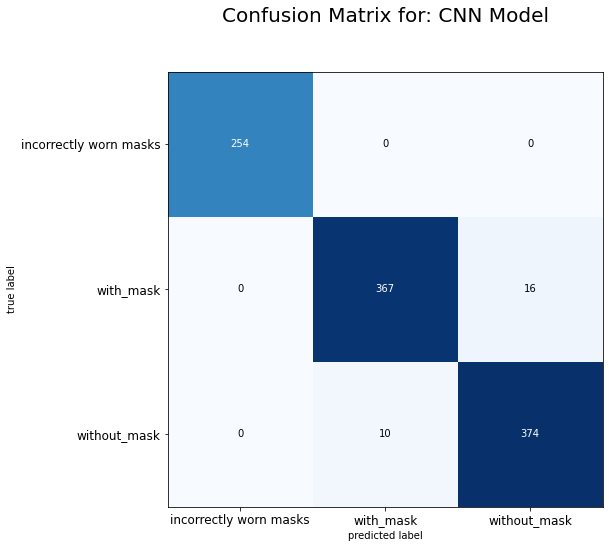




------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
                        precision    recall  f1-score   support

incorrectly worn masks       1.00      1.00      1.00       254
             with_mask       0.97      0.96      0.97       383
          without_mask       0.96      0.97      0.97       384

              accuracy                           0.97      1021
             macro avg       0.98      0.98      0.98      1021
          weighted avg       0.97      0.97      0.97      1021

------------------------------------------------------------------------------------------


In [13]:
plot_confusion_test(model_CNN,'CNN Model')

# Hyperparameter Tuning

# MobileNetV2

In [8]:
# Load and configure model InceptionV3 for fine-tuning with new class labels
def get_model_MobileNetV2(input_shape=(224, 224, 3)):    
    
#     base_model = InceptionV3(weights=None, include_top=False)
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    headModel = base_model.output
    headModel = AveragePooling2D(pool_size=(2, 2))(headModel)

    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(128, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(3, activation="softmax")(headModel)

    model = Model(inputs=base_model.input, outputs=headModel)

    for layer in base_model.layers:
        layer.trainable = False 
    ##fixed learning rate
    opt=keras.optimizers.Adam(learning_rate=1e-3,amsgrad=True)
    # opt=SGD(learning_rate=0.1, momentum=0.9)
    metrics=[
         f1,    
        'accuracy',
    tf.keras.metrics.AUC(name='AUC')]
    model.compile(loss=tf.keras.losses.categorical_crossentropy,optimizer =opt,
                  metrics=metrics)    
    return model


In [9]:
model_Mobile=get_model_MobileNetV2()
model_Mobile.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
____________________________________________________________________________________________

In [10]:
len(model_Mobile.layers)

160

# Training model and plotting CM

In [18]:
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=2,min_lr=1e-7,verbose=1)
mc = ModelCheckpoint('3 classes mask MobileNet.h5', monitor='val_accuracy', mode='max', verbose=1,save_best_only=True)

with tf.device('/gpu:0'):
    history = model_Mobile.fit(aug.flow(X_train, Y_train, batch_size=BS),
                steps_per_epoch=len(X_train) // BS,
                validation_data=(X_test, Y_test),
                validation_steps=len(X_test) // BS,
                callbacks=[mc,reduce_lr],
                epochs=20)

Epoch 1/20
127/127 [==============================] - 61s 477ms/step - loss: 0.4374 - f1: 0.8645 - accuracy: 0.8659 - AUC: 0.8994 - val_loss: 0.1760 - val_f1: 0.9403 - val_accuracy: 0.9393 - val_AUC: 0.9629

Epoch 00001: val_accuracy improved from -inf to 0.93928, saving model to 3 classes mask MobileNet.h5
Epoch 2/20
127/127 [==============================] - 57s 445ms/step - loss: 0.1973 - f1: 0.9265 - accuracy: 0.9257 - AUC: 0.9724 - val_loss: 0.1246 - val_f1: 0.9515 - val_accuracy: 0.9510 - val_AUC: 0.9781

Epoch 00002: val_accuracy improved from 0.93928 to 0.95103, saving model to 3 classes mask MobileNet.h5
Epoch 3/20
127/127 [==============================] - 54s 424ms/step - loss: 0.1652 - f1: 0.9415 - accuracy: 0.9415 - AUC: 0.9813 - val_loss: 0.1556 - val_f1: 0.9525 - val_accuracy: 0.9530 - val_AUC: 0.9833

Epoch 00003: val_accuracy improved from 0.95103 to 0.95299, saving model to 3 classes mask MobileNet.h5
Epoch 4/20
127/127 [==============================] - 53s 419ms/ste

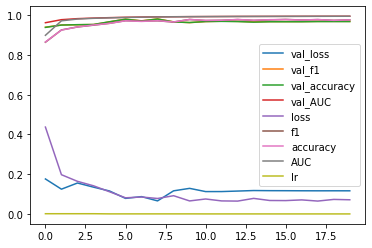

In [19]:
import matplotlib
from matplotlib import pyplot as plt

for key in history.history.keys():
    plt.plot(history.history[key],label=key)
plt.legend()
plt.show()

In [20]:
model_Mobile.load_weights('3 classes mask MobileNet.h5')

results
------------------------------------------------------------------------------------------
Derived Report
------------------------------------------------------------------------------------------
Precision     : 98.14%
Recall        : 98.14%
F1-Score      : 98.14%
------------------------------------------------------------------------------------------





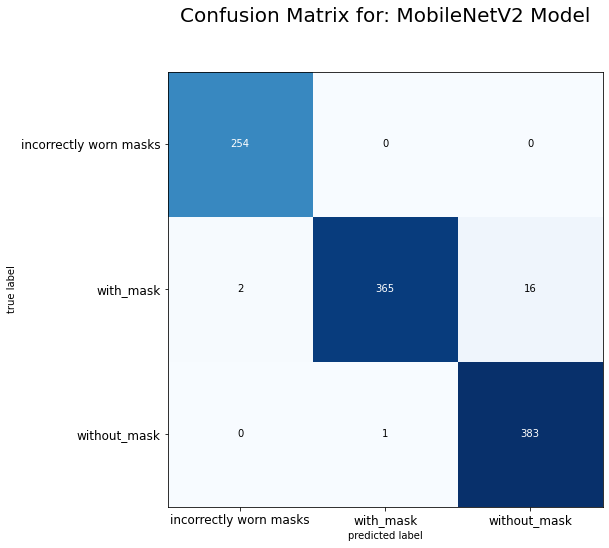




------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
                        precision    recall  f1-score   support

incorrectly worn masks       0.99      1.00      1.00       254
             with_mask       1.00      0.95      0.97       383
          without_mask       0.96      1.00      0.98       384

              accuracy                           0.98      1021
             macro avg       0.98      0.98      0.98      1021
          weighted avg       0.98      0.98      0.98      1021

------------------------------------------------------------------------------------------


In [21]:
plot_confusion_test(model_Mobile,'MobileNetV2 Model')

# Residual Network AttentionResNet92

In [11]:
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import UpSampling2D
from keras.layers import Activation
from keras.layers import MaxPool2D
from keras.layers import Add
from keras.layers import Multiply
from keras.layers import Lambda


def residual_block(input, input_channels=None, output_channels=None, kernel_size=(3, 3), stride=1):
    """
    full pre-activation residual block
    https://arxiv.org/pdf/1603.05027.pdf
    """
    if output_channels is None:
        output_channels = input.get_shape()[-1]
    if input_channels is None:
        input_channels = output_channels // 4

    strides = (stride, stride)

    x = BatchNormalization()(input)
    x = Activation('relu')(x)
    x = Conv2D(input_channels, (1, 1))(x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(input_channels, kernel_size, padding='same', strides=stride)(x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(output_channels, (1, 1), padding='same')(x)

    if input_channels != output_channels or stride != 1:
        input = Conv2D(output_channels, (1, 1), padding='same', strides=strides)(input)

    x = Add()([x, input])
    return x


def attention_block(input, input_channels=None, output_channels=None, encoder_depth=1):
    """
    attention block
    https://arxiv.org/abs/1704.06904
    """

    p = 1
    t = 2
    r = 1

    if input_channels is None:
        input_channels = input.get_shape()[-1]
    if output_channels is None:
        output_channels = input_channels

    # First Residual Block
    for i in range(p):
        input = residual_block(input)

    # Trunc Branch
    output_trunk = input
    for i in range(t):
        output_trunk = residual_block(output_trunk)

    # Soft Mask Branch

    ## encoder
    ### first down sampling
    output_soft_mask = MaxPool2D(padding='same')(input)  # 32x32
    for i in range(r):
        output_soft_mask = residual_block(output_soft_mask)

    skip_connections = []
    for i in range(encoder_depth - 1):

        ## skip connections
        output_skip_connection = residual_block(output_soft_mask)
        skip_connections.append(output_skip_connection)
        # print ('skip shape:', output_skip_connection.get_shape())

        ## down sampling
        output_soft_mask = MaxPool2D(padding='same')(output_soft_mask)
        for _ in range(r):
            output_soft_mask = residual_block(output_soft_mask)

            ## decoder
    skip_connections = list(reversed(skip_connections))
    for i in range(encoder_depth - 1):
        ## upsampling
        for _ in range(r):
            output_soft_mask = residual_block(output_soft_mask)
        output_soft_mask = UpSampling2D()(output_soft_mask)
        ## skip connections
        output_soft_mask = Add()([output_soft_mask, skip_connections[i]])

    ### last upsampling
    for i in range(r):
        output_soft_mask = residual_block(output_soft_mask)
    output_soft_mask = UpSampling2D()(output_soft_mask)

    ## Output
    output_soft_mask = Conv2D(input_channels, (1, 1))(output_soft_mask)
    output_soft_mask = Conv2D(input_channels, (1, 1))(output_soft_mask)
    output_soft_mask = Activation('softmax')(output_soft_mask)

    # Attention: (1 + output_soft_mask) * output_trunk
    output = Lambda(lambda x: x + 1)(output_soft_mask)
    output = Multiply()([output, output_trunk])  #

    # Last Residual Block
    for i in range(p):
        output = residual_block(output)

    return output

In [12]:
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Dense
from keras.layers import AveragePooling2D
from keras.layers import Flatten
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.models import Model
from keras.regularizers import l2


def AttentionResNet92(shape=(224, 224, 3), n_channels=3, n_classes=100,
                      dropout=0, regularization=0.01):
    """
    Attention-92 ResNet
    https://arxiv.org/abs/1704.06904
    """
    regularizer = l2(regularization)

    input_ = Input(shape=shape)
    x = Conv2D(n_channels, (7, 7), strides=(2, 2), padding='same')(input_) # 112x112

    x = Conv2D(n_channels, (3, 3), strides=(2, 2), padding='same')(input_) # 112x112
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)  # 56x56

    x = residual_block(x, output_channels=n_channels * 4)  # 56x56
    x = attention_block(x, encoder_depth=3)  # bottleneck 7x7

    x = residual_block(x, output_channels=n_channels * 8, stride=2)  # 28x28
    x = attention_block(x, encoder_depth=2)  # bottleneck 7x7
    x = attention_block(x, encoder_depth=2)  # bottleneck 7x7

    x = residual_block(x, output_channels=n_channels * 16, stride=2)  # 14x14
    x = attention_block(x, encoder_depth=1)  # bottleneck 7x7
    x = attention_block(x, encoder_depth=1)  # bottleneck 7x7
    x = attention_block(x, encoder_depth=1)  # bottleneck 7x7

    x = residual_block(x, output_channels=n_channels * 32, stride=2)  # 7x7
    x = residual_block(x, output_channels=n_channels * 32)
    x = residual_block(x, output_channels=n_channels * 32)

    pool_size = (x.get_shape()[1], x.get_shape()[2])
    x = AveragePooling2D(pool_size=pool_size, strides=(1, 1))(x)
    x = Flatten()(x)
    if dropout:
        x = Dropout(dropout)(x)
#     x=Dense(1024, kernel_regularizer=regularizer, activation='relu')(x)
#     x=Dense(512, kernel_regularizer=regularizer, activation='relu')(x)
#     x=Dense(64, kernel_regularizer=regularizer, activation='relu')(x)
#     x=Dense(32, kernel_regularizer=regularizer, activation='relu')(x)
    output = Dense(n_classes, kernel_regularizer=regularizer, activation='softmax')(x)

    model = Model(input_, output)
    return model



In [13]:
def get_model_AttentionResNet92():
    model=AttentionResNet92(n_classes=3)
    metrics=[
       f1,    
        'accuracy',
    tf.keras.metrics.AUC(name='AUC')
    ]
    opt=keras.optimizers.Adam(learning_rate=1e-3,amsgrad=True)

    model.compile(loss=tf.keras.losses.categorical_crossentropy,optimizer =opt,
                  metrics=metrics)
    return model


In [15]:
len(model_Attention.layers)

656

In [14]:
model_Attention=get_model_AttentionResNet92()
model_Attention.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 112, 112, 3)  84          input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 112, 112, 3)  12          conv2d_8[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 3)  0           batch_normalization_4[0][0]      
____________________________________________________________________________________________

In [12]:
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=2,min_lr=1e-7,verbose=1)
mc = ModelCheckpoint('test Attention.h5', monitor='val_accuracy', mode='max', verbose=1,save_best_only=True)

with tf.device('/gpu:0'):
    history = model_Attention.fit(aug.flow(X_train, Y_train, batch_size=BS),
                steps_per_epoch=len(X_train) // BS,
                validation_data=(X_test, Y_test),
                validation_steps=len(X_test) // BS,
                callbacks=[mc,reduce_lr],
                epochs=20)

Epoch 1/20
127/127 [==============================] - 130s 1s/step - loss: 0.7096 - f1: 0.7124 - accuracy: 0.7296 - AUC: 0.7880 - val_loss: 2.3755 - val_f1: 0.3752 - val_accuracy: 0.3751 - val_AUC: 0.8356

Epoch 00001: val_accuracy improved from -inf to 0.37512, saving model to test Attention.h5
Epoch 2/20
127/127 [==============================] - 74s 583ms/step - loss: 0.4123 - f1: 0.8621 - accuracy: 0.8617 - AUC: 0.8500 - val_loss: 2.4684 - val_f1: 0.3963 - val_accuracy: 0.3986 - val_AUC: 0.8634

Epoch 00002: val_accuracy improved from 0.37512 to 0.39863, saving model to test Attention.h5
Epoch 3/20
127/127 [==============================] - 71s 558ms/step - loss: 0.3563 - f1: 0.8822 - accuracy: 0.8834 - AUC: 0.8722 - val_loss: 0.7141 - val_f1: 0.7126 - val_accuracy: 0.7150 - val_AUC: 0.8905

Epoch 00003: val_accuracy improved from 0.39863 to 0.71499, saving model to test Attention.h5
Epoch 4/20
127/127 [==============================] - 74s 582ms/step - loss: 0.3245 - f1: 0.8905 - 

In [13]:
model_Attention.load_weights('test Attention.h5')

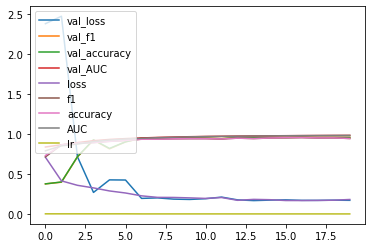

In [14]:
import matplotlib
from matplotlib import pyplot as plt

for key in history.history.keys():
    plt.plot(history.history[key],label=key)
plt.legend()
plt.show()

results
------------------------------------------------------------------------------------------
Derived Report
------------------------------------------------------------------------------------------
Precision     : 95.69%
Recall        : 95.69%
F1-Score      : 95.69%
------------------------------------------------------------------------------------------





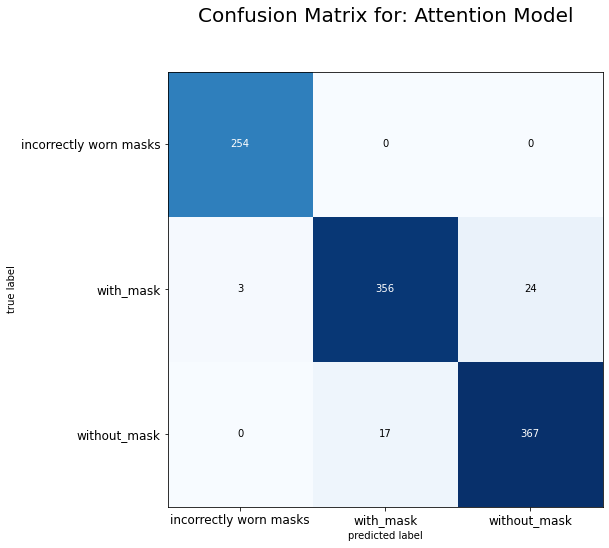




------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
                        precision    recall  f1-score   support

incorrectly worn masks       0.99      1.00      0.99       254
             with_mask       0.95      0.93      0.94       383
          without_mask       0.94      0.96      0.95       384

              accuracy                           0.96      1021
             macro avg       0.96      0.96      0.96      1021
          weighted avg       0.96      0.96      0.96      1021

------------------------------------------------------------------------------------------


In [15]:
plot_confusion_test(model_Attention,'Attention Model')

In [23]:
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=2,min_lr=1e-7,verbose=1)
mc = ModelCheckpoint('3 classes mask Attention.h5', monitor='val_accuracy', mode='max', verbose=1,save_best_only=True)

with tf.device('/gpu:0'):
    history = model_Attention.fit(aug.flow(X_train, Y_train, batch_size=BS),
                steps_per_epoch=len(X_train) // BS,
                validation_data=(X_test, Y_test),
                validation_steps=len(X_test) // BS,
                callbacks=[mc,reduce_lr],
                epochs=20)

Epoch 1/20
127/127 [==============================] - 133s 1s/step - loss: 0.8480 - f1: 0.6401 - accuracy: 0.6686 - AUC: 0.7303 - val_loss: 1.7216 - val_f1: 0.4477 - val_accuracy: 0.4525 - val_AUC: 0.8092

Epoch 00001: val_accuracy improved from -inf to 0.45250, saving model to 3 classes mask Attention.h5
Epoch 2/20
127/127 [==============================] - 72s 568ms/step - loss: 0.4199 - f1: 0.8636 - accuracy: 0.8656 - AUC: 0.8412 - val_loss: 1.0020 - val_f1: 0.6778 - val_accuracy: 0.6699 - val_AUC: 0.8772

Epoch 00002: val_accuracy improved from 0.45250 to 0.66993, saving model to 3 classes mask Attention.h5
Epoch 3/20
127/127 [==============================] - 72s 565ms/step - loss: 0.3416 - f1: 0.8960 - accuracy: 0.8975 - AUC: 0.8950 - val_loss: 0.2922 - val_f1: 0.9125 - val_accuracy: 0.9138 - val_AUC: 0.9145

Epoch 00003: val_accuracy improved from 0.66993 to 0.91381, saving model to 3 classes mask Attention.h5
Epoch 4/20
127/127 [==============================] - 71s 560ms/step 

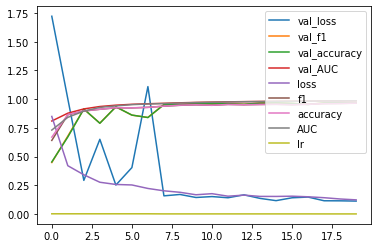

In [24]:
import matplotlib
from matplotlib import pyplot as plt

for key in history.history.keys():
    plt.plot(history.history[key],label=key)
plt.legend()
plt.show()

In [22]:
model_Attention.load_weights('3 classes mask Attention.h5')

results
------------------------------------------------------------------------------------------
Derived Report
------------------------------------------------------------------------------------------
Precision     : 96.96%
Recall        : 96.96%
F1-Score      : 96.96%
------------------------------------------------------------------------------------------





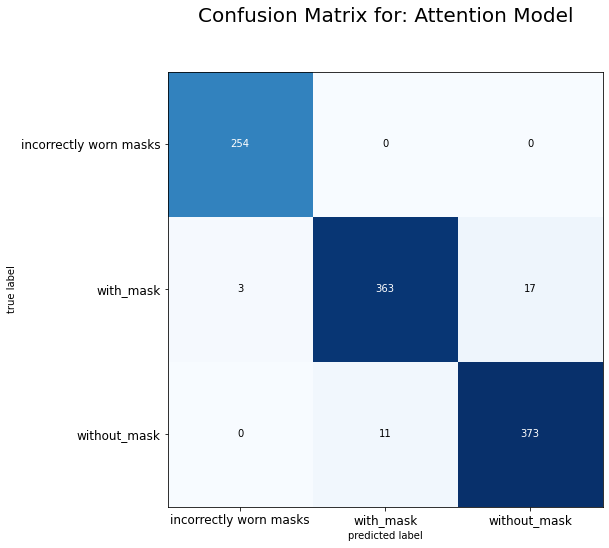




------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
                        precision    recall  f1-score   support

incorrectly worn masks       0.99      1.00      0.99       254
             with_mask       0.97      0.95      0.96       383
          without_mask       0.96      0.97      0.96       384

              accuracy                           0.97      1021
             macro avg       0.97      0.97      0.97      1021
          weighted avg       0.97      0.97      0.97      1021

------------------------------------------------------------------------------------------


In [23]:
plot_confusion_test(model_Attention,'Attention Model')

# DenseNet121

In [5]:
# Load and configure model InceptionV3 for fine-tuning with new class labels
def get_model_DenseNet121(input_shape=(224, 224, 3)):    
    
#     base_model = InceptionV3(weights=None, include_top=False)
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
    headModel = base_model.output
    headModel = AveragePooling2D(pool_size=(2, 2))(headModel)

    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(128, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(3, activation="softmax")(headModel)

    model = Model(inputs=base_model.input, outputs=headModel)

    for layer in base_model.layers:
        layer.trainable = False 
    ##fixed learning rate
    opt=keras.optimizers.Adam(learning_rate=1e-3,amsgrad=True)
    # opt=SGD(learning_rate=0.1, momentum=0.9)
    metrics=[
         f1,    
        'accuracy',
    tf.keras.metrics.AUC(name='AUC')]
    model.compile(loss=tf.keras.losses.categorical_crossentropy,optimizer =opt,
                  metrics=metrics)    
    return model


In [6]:
model_DenseNet=get_model_DenseNet121()
model_DenseNet.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [10]:
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=2,min_lr=1e-7,verbose=1)
mc = ModelCheckpoint('3 classes mask DenseNet.h5', monitor='val_accuracy', mode='max', verbose=1,save_best_only=True)

with tf.device('/gpu:0'):
    history = model_DenseNet.fit(aug.flow(X_train, Y_train, batch_size=BS),
                steps_per_epoch=len(X_train) // BS,
                validation_data=(X_test, Y_test),
                validation_steps=len(X_test) // BS,
                callbacks=[mc,reduce_lr],
                epochs=20)

Epoch 1/20
127/127 [==============================] - 102s 807ms/step - loss: 0.4771 - f1: 0.8633 - accuracy: 0.8649 - AUC: 0.8820 - val_loss: 0.0883 - val_f1: 0.9673 - val_accuracy: 0.9667 - val_AUC: 0.9594

Epoch 00001: val_accuracy improved from -inf to 0.96670, saving model to 3 classes mask DenseNet.h5
Epoch 2/20
127/127 [==============================] - 85s 673ms/step - loss: 0.1414 - f1: 0.9474 - accuracy: 0.9489 - AUC: 0.9731 - val_loss: 0.0803 - val_f1: 0.9707 - val_accuracy: 0.9706 - val_AUC: 0.9800

Epoch 00002: val_accuracy improved from 0.96670 to 0.97062, saving model to 3 classes mask DenseNet.h5
Epoch 3/20
127/127 [==============================] - 86s 674ms/step - loss: 0.1062 - f1: 0.9592 - accuracy: 0.9590 - AUC: 0.9837 - val_loss: 0.0687 - val_f1: 0.9795 - val_accuracy: 0.9794 - val_AUC: 0.9866

Epoch 00003: val_accuracy improved from 0.97062 to 0.97943, saving model to 3 classes mask DenseNet.h5
Epoch 4/20
127/127 [==============================] - 86s 677ms/step 

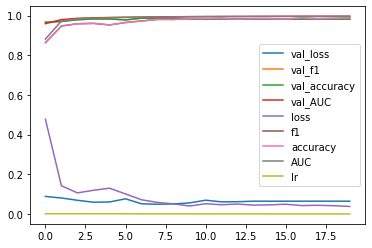

In [11]:
import matplotlib
from matplotlib import pyplot as plt

for key in history.history.keys():
    plt.plot(history.history[key],label=key)
plt.legend()
plt.show()

In [12]:
model_DenseNet.load_weights('3 classes mask DenseNet.h5')

results
------------------------------------------------------------------------------------------
Derived Report
------------------------------------------------------------------------------------------
Precision     : 98.73%
Recall        : 98.73%
F1-Score      : 98.73%
------------------------------------------------------------------------------------------





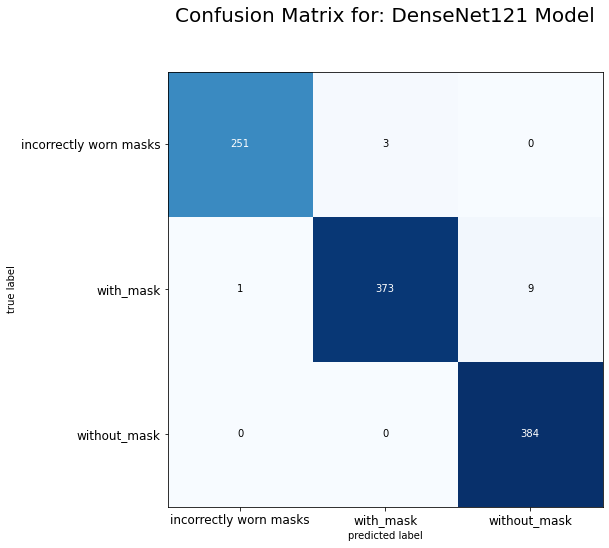




------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
                        precision    recall  f1-score   support

incorrectly worn masks       1.00      0.99      0.99       254
             with_mask       0.99      0.97      0.98       383
          without_mask       0.98      1.00      0.99       384

              accuracy                           0.99      1021
             macro avg       0.99      0.99      0.99      1021
          weighted avg       0.99      0.99      0.99      1021

------------------------------------------------------------------------------------------


In [13]:
plot_confusion_test(model_DenseNet,'DenseNet121 Model')

# Video stream

# Load Models

# README
1. run the libraries above
2. run the functions above that build the models 
3. load their weights below

In [12]:
model_CNN=get_model_CNN()
#loading best weights for CNN
model_CNN.load_weights('3 classes mask CNN 2.h5')

NameError: name 'get_model_CNN' is not defined

In [28]:
from tensorflow.keras.models import load_model
# model_Mobile=load_model('MobileNet_3_classes_3Epochs_96x96')
#load best weights for MobileNetV2
model_Mobile=get_model_MobileNetV2()
model_Mobile.load_weights('3 classes mask Mobile')

In [8]:
#load best weights for AttentionResNet92
model_Attention=get_model_AttentionResNet92()
model_Attention.load_weights('3 classes mask Attention.h5')

In [7]:
#load best weights for DenseNet121
model_DenseNet=get_model_DenseNet121()
model_DenseNet.load_weights('3 classes mask DenseNet.h5')

In [8]:
# import the necessary packages
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
import numpy as np
import imutils
import time
import cv2
import os

def detect_and_predict_mask(frame, faceNet, maskNet):
    # grab the dimensions of the frame and then construct a blob
    # from it
    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 1.0, (224, 224),
        (104.0, 177.0, 123.0))

    # pass the blob through the network and obtain the face detections
    faceNet.setInput(blob)
    detections = faceNet.forward()
#     print(detections.shape)

    # initialize our list of faces, their corresponding locations,
    # and the list of predictions from our face mask network
    faces = []
    locs = []
    preds = []

    # loop over the detections
    for i in range(0, detections.shape[2]):
        # extract the confidence (i.e., probability) associated with
        # the detection
        confidence = detections[0, 0, i, 2]

        # filter out weak detections by ensuring the confidence is
        # greater than the minimum confidence
        if confidence > 0.5:
            # compute the (x, y)-coordinates of the bounding box for
            # the object
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

            # ensure the bounding boxes fall within the dimensions of
            # the frame
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

            # extract the face ROI, convert it from BGR to RGB channel
            # ordering, resize it to 224x224, and preprocess it
            face = frame[startY:endY, startX:endX]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)

            # add the face and bounding boxes to their respective
            # lists
            faces.append(face)
            locs.append((startX, startY, endX, endY))

    # only make a predictions if at least one face was detected
    if len(faces) > 0:
        # for faster inference we'll make batch predictions on *all*
        # faces at the same time rather than one-by-one predictions
        # in the above `for` loop
        faces = np.array(faces, dtype="float32")
        preds = maskNet.predict(faces, batch_size=32)

    # return a 2-tuple of the face locations and their corresponding
    # locations
    return (locs, preds)



In [9]:
# load our serialized face detector model from disk
prototxtPath = "C:/Users/Salim/Desktop/deploy.prototxt"
weightsPath = "C:/Users/Salim/Desktop/res10_300x300_ssd_iter_140000.caffemodel"
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

# initialize the video stream
print("[INFO] starting video stream...")
vs = VideoStream(src=0).start()

[INFO] starting video stream...


In [10]:
def pred_frame(model):
    # loop over the frames from the video stream
    while True:
        # grab the frame from the threaded video stream and resize it
        # to have a maximum width of 400 pixels
        frame = vs.read()
        frame = imutils.resize(frame, width=400)

        # detect faces in the frame and determine if they are wearing a
        # face mask or not
    
        start_time = time.clock()
        (locs, preds) = detect_and_predict_mask(frame, faceNet, model)
        end_time=time.clock()

        # loop over the detected face locations and their corresponding
        # locations

        for (box, pred) in zip(locs, preds):
            # unpack the bounding box and predictions
            (startX, startY, endX, endY) = box
            (incorrectly,mask, withoutMask) = pred

        # determine the class label and color we'll use to draw
        # the bounding box and text
        if mask>withoutMask and mask>incorrectly:
            label = "Mask"
            color = (0, 255, 0)
        elif withoutMask > mask and withoutMask > incorrectly:
            label = "No Mask"
            color = (0, 0, 255)
        elif incorrectly>mask and incorrectly>withoutMask:
            label = "incorrectly"
            color = (255, 0, 0)
        # include the probability in the label
        # include the probability in the label
        label = "{}: {:.2f}%".format(label, max(mask, withoutMask,incorrectly) * 100)
        # display the label and bounding box rectangle on the output
        # frame
        cv2.putText(frame, label, (startX, startY - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)

        # show the output frame
        cv2.imshow("Frame", frame)

        key = cv2.waitKey(1) & 0xFF
        # if the `q` key was pressed, break from the loop
        if key == ord("q"):
            break

    # do a bit of cleanup
    cv2.destroyAllWindows()
    vs.stop()
    return start_time,end_time

In [11]:
start_time,end_time=pred_frame(model_DenseNet)

C:\Users\Salim\AppData\Roaming\SPB_Data\.conda\envs\gpu\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if sys.path[0] == '':
C:\Users\Salim\AppData\Roaming\SPB_Data\.conda\envs\gpu\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


In [12]:
start_time,end_time=pred_frame(model_Attention)

C:\Users\Salim\AppData\Roaming\SPB_Data\.conda\envs\gpu\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if sys.path[0] == '':
C:\Users\Salim\AppData\Roaming\SPB_Data\.conda\envs\gpu\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


In [10]:
start_time,end_time=pred_frame(model_CNN)

C:\Users\Salim\AppData\Roaming\SPB_Data\.conda\envs\gpu\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if sys.path[0] == '':
C:\Users\Salim\AppData\Roaming\SPB_Data\.conda\envs\gpu\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


In [28]:
start_time,end_time=pred_frame(model_CNN)

C:\Users\Salim\AppData\Roaming\SPB_Data\.conda\envs\gpu\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if sys.path[0] == '':
C:\Users\Salim\AppData\Roaming\SPB_Data\.conda\envs\gpu\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)


In [29]:
print("--- %s seconds for CNN ---" % (end_time - start_time))

--- 0.029782300000022133 seconds for CNN ---


In [25]:
start_time,end_time=pred_frame(model_Mobile)

C:\Users\Salim\AppData\Roaming\SPB_Data\.conda\envs\gpu\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if sys.path[0] == '':
C:\Users\Salim\AppData\Roaming\SPB_Data\.conda\envs\gpu\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)


In [26]:
print("--- %s seconds for MobileNet ---" % (end_time - start_time))

--- 0.04828870000000052 seconds for MobileNet ---


In [30]:
start_time,end_time=pred_frame(model_Attention)

C:\Users\Salim\AppData\Roaming\SPB_Data\.conda\envs\gpu\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if sys.path[0] == '':


(1, 1, 200, 7)


C:\Users\Salim\AppData\Roaming\SPB_Data\.conda\envs\gpu\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)


In [31]:
print("--- %s seconds for AttentionNet ---" % (end_time - start_time))

--- 0.06287589999999454 seconds for AttentionNet ---


In [23]:
start_time,end_time=pred_frame(model_Mobile)

C:\Users\Salim\AppData\Roaming\SPB_Data\.conda\envs\gpu\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if sys.path[0] == '':
C:\Users\Salim\AppData\Roaming\SPB_Data\.conda\envs\gpu\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200

In [13]:
model_CNN_2=get_model_CNN_2()
model_CNN_2.load_weights('3 classes mask CNN_2.h5')

In [18]:
start_time,end_time=pred_frame(model_CNN_2)

C:\Users\Salim\AppData\Roaming\SPB_Data\.conda\envs\gpu\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if sys.path[0] == '':
C:\Users\Salim\AppData\Roaming\SPB_Data\.conda\envs\gpu\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
